# 프로젝트 : SRGAN 활용하기

# 프로젝트 1: 직접 고른 이미지로 SRGAN 실험하기

## 프로젝트 1-1. 고해상도 이미지

### 1) 고해상도 이미지 불러오기

(500, 780, 3)


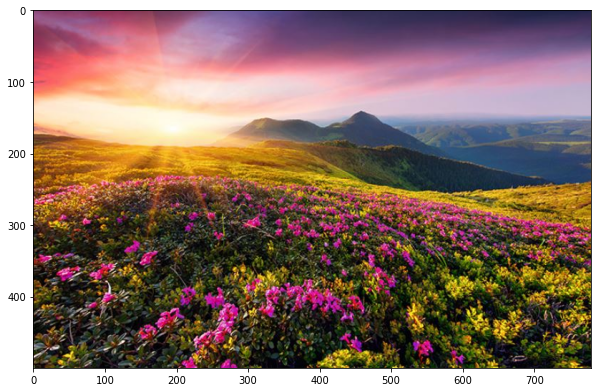

In [33]:
import cv2
import os
from skimage import data
import matplotlib.pyplot as plt

image_path = os.getenv('HOME')+'/aiffel/super_resolution/img1.jpg'
hr_image = cv2.imread(image_path)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)    # 이미지의 크기를 출력합니다.

plt.figure(figsize=(10,10))
plt.imshow(hr_image)

### 2) bicubic interpolation을 적용과 1/4 리사이즈

(125, 195, 3)


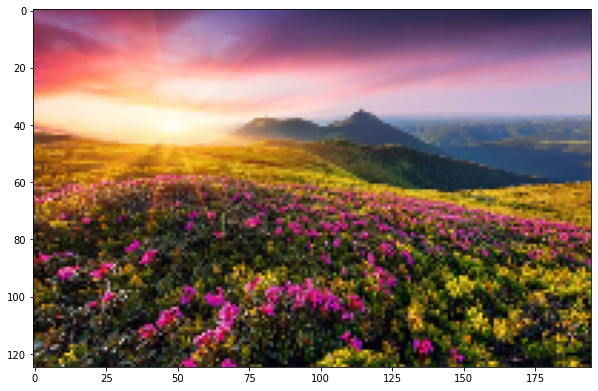

In [21]:
lr_image = cv2.resize(hr_image, dsize=(hr_image.shape[1]//4,hr_image.shape[0]//4)) # (가로 픽셀 수, 세로 픽셀 수)
print(lr_image.shape)

plt.figure(figsize=(10,10))
plt.imshow(lr_image)

### 3) SRGAN을 이용해 고해상도 이미지를 생성

줄인 저해상도 이미지를 입력으로 넣어 고해상도 이미지를 생성합니다. 

In [22]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [23]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr_image)

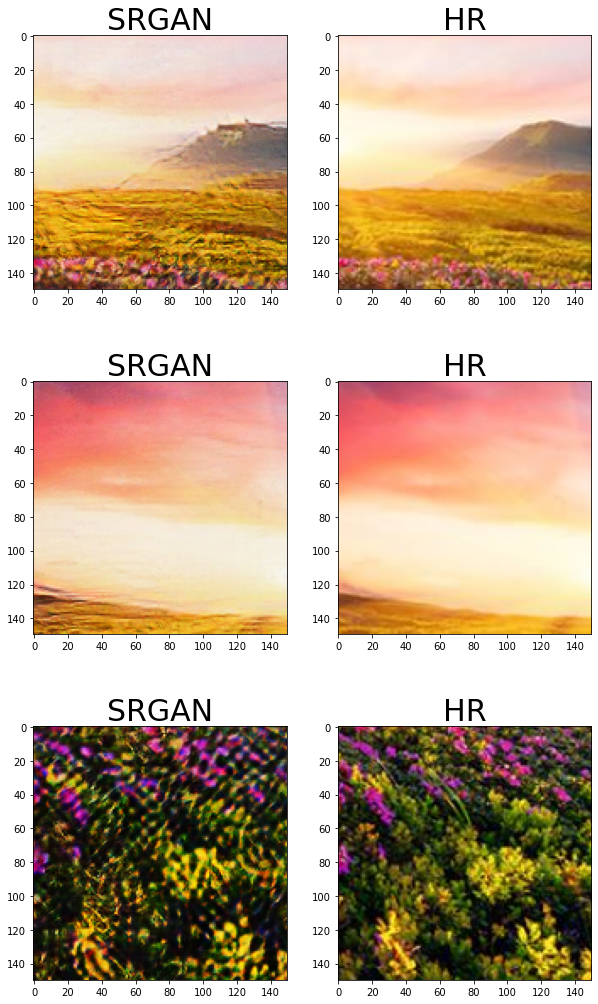

In [25]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,200), (50,40), (300,500)]

images = []
for left_top in left_tops:
    img1 = crop(srgan_hr, left_top, 150, 150)
    img2 = crop(hr_image, left_top, 150, 150)
    images.extend([img1, img2])
    
labels = ["SRGAN", "HR"] * 3

plt.figure(figsize=(10,18))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 4) `2`번 이미지에 bicubic interpolation을 적용해 가로세로 픽셀 수를 다시 4배로 늘립니다.  

bicubic: (500, 780, 3)


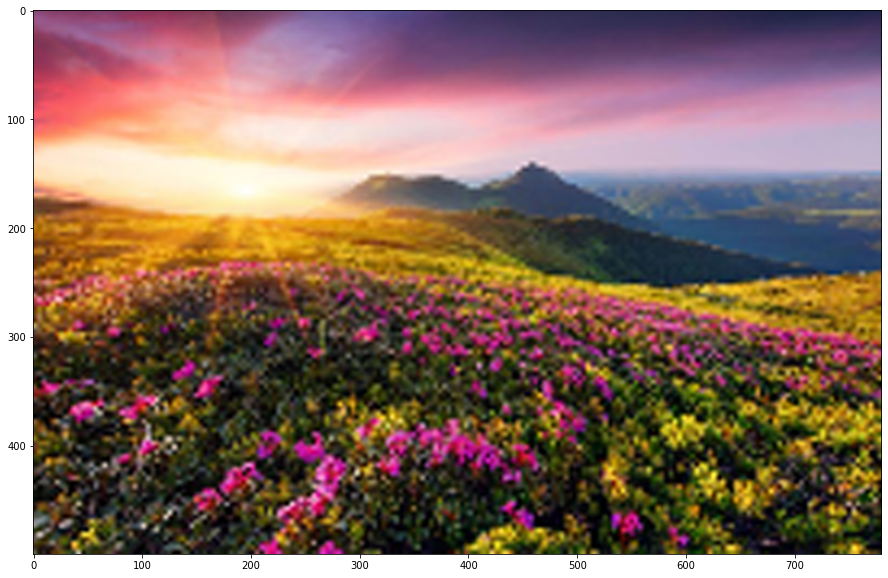

In [26]:
bicubic_hr = cv2.resize(lr_image, dsize=(hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_CUBIC) # 원본사이즈로 복원
print('bicubic:', hr_image.shape)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_hr)

### 5) 3개 이미지(Bicubic, SRGAN, 원본)를 나란히 시각화합니다.  

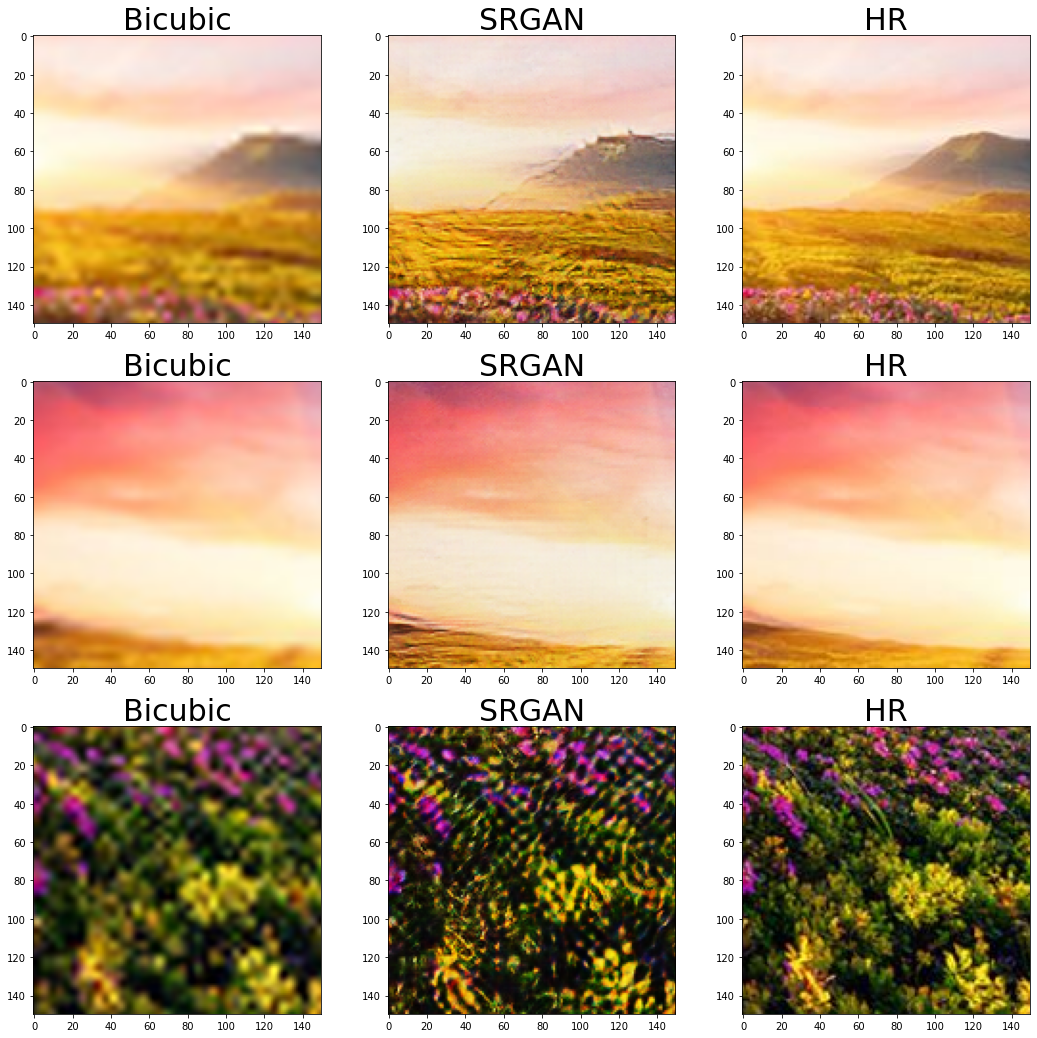

In [27]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,200), (50,40), (300,500)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 150, 150)
    img2 = crop(srgan_hr, left_top, 150, 150)
    img3 = crop(hr_image, left_top, 150, 150)
    images.extend([img1, img2, img3])
    
labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 6) 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution한 결론

**결과**  

- DIV2K 데이터셋에서 학습된 모델은 확실히 흐릿했던 부분을 선명하게 해주었습니다.  

- 완벽하다고 볼 수는 없지만 Resolution을 높이는 부분에 있어서는 유의미한 결과를 내었다고 생각합니다.  



## 프로젝트 1-2. 저해상도 이미지

### 1) 저해상도 이미지 불러오기

In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

(977, 800, 3)


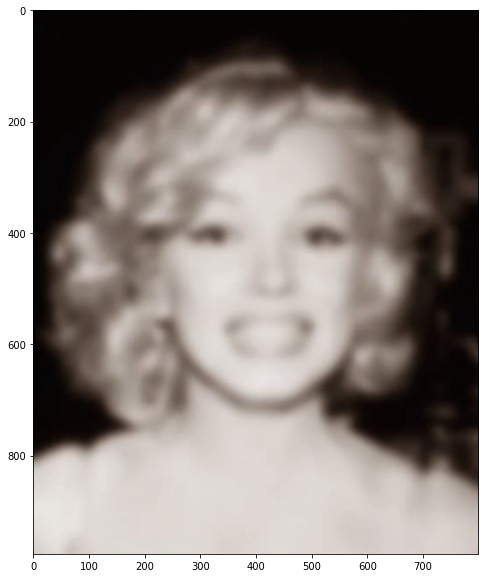

In [37]:
image_path = os.getenv('HOME')+'/aiffel/super_resolution/marliyn monroe.jpg'
lr_image = cv2.imread(image_path)
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)

print(lr_image.shape)    # 이미지의 크기를 출력합니다.

plt.figure(figsize=(10,10))
plt.imshow(lr_image)

### 2) 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지 생성

불러온 이미지가 이미 상태는 안좋지만 나름 고해상도(977, 800)라 아래 SRGAN을 돌리면 메모리 에러가 발생해 1/2로 픽셀 수를 줄여줬습니다.  

In [40]:
lr_image = cv2.resize(lr_image, dsize=(lr_image.shape[1]//2, lr_image.shape[0]//2))

# SRGAN으로 고해상도 이미지 생성
srgan_hr = apply_srgan(lr_image)

### 3) 불러온 이미지에 bicubic interpolation을 적용해 가로 세로 픽셀 수를 4배로 늘립니다.

In [42]:
bicubic_hr = cv2.resize(lr_image, dsize=(lr_image.shape[1]*4, lr_image.shape[0]*4), interpolation=cv2.INTER_CUBIC)

print(bicubic_hr.shape)

(1952, 1600, 3)


### 4) 2개 이미지(Bicubic, SRGAN)를 시각화 합니다.  

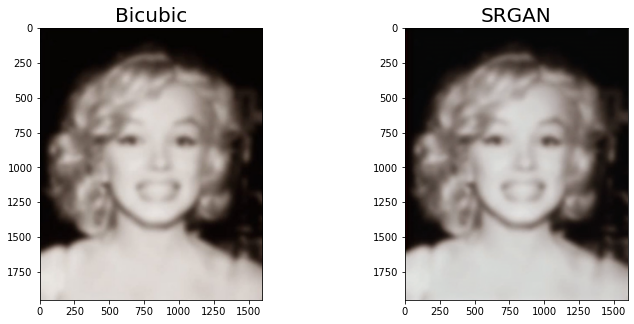

In [43]:
# 시각화
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (lr_image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(lr_image)
    plt.title(title, fontsize=20)

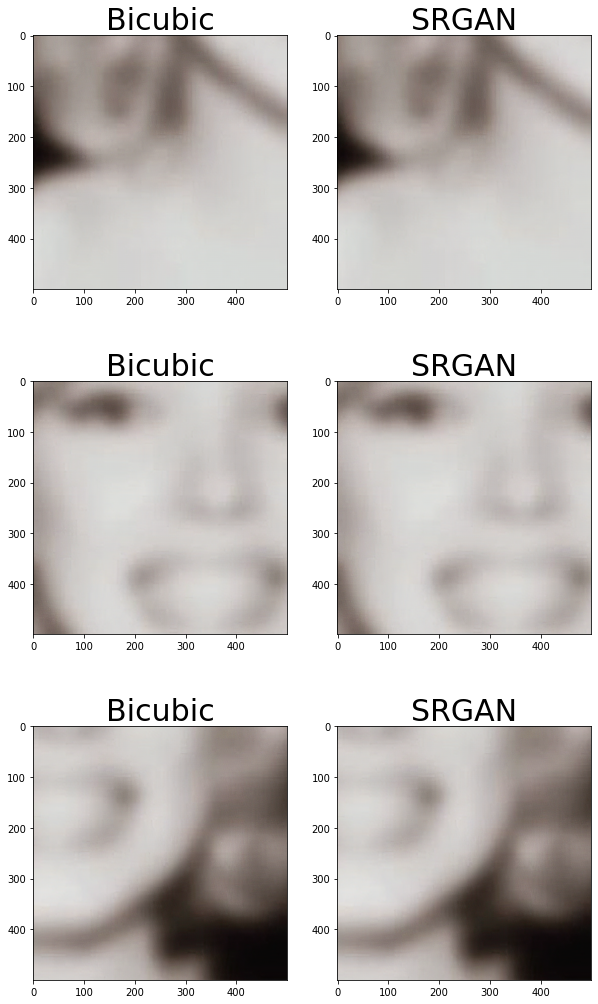

In [47]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(1250,250), (750,500), (1000,800)]

images = []
for left_top in left_tops:
    img1 = crop(lr_image, left_top, 500, 500)
    img2 = crop(srgan_hr, left_top, 500, 500)
    images.extend([img1, img2])
    
labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(10,18))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 6) 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution한 결론

- 완전히 모자이크된 얼굴을 SRGAN만으로 복원하기는 어려울 것 같아 적당히 흐릿한 이미지를 선택한 결과입니다.

- 흐릿한 이미지로 SRGAN을 사용해 선명하게 하는 것에는 한계가 있는 것을 확인할 수 있었습니다.  

프로젝트 1-1을 보면 SRGAN을 사용시 선명해지지만 부자연스러워졌습니다. 이를 사람의 얼굴에 적용하면 어떻게 될지 궁금해서 실험한 결과인데 결과가 좋지 못해 나중에 시간이 남으면 조금 더 선명한 이미지로 시도해보려고 합니다.

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성

단일 이미지가 아닌 영상에 대해 Super Resolution을 적용해봅니다.  

SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고 프레임을 합쳐 동영상으로 만듭니다.  

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.  

`pip install imageio`

### 1) gif 파일 불러오기

In [52]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME')+'/aiffel/super_resolution/'
gif = cv2.VideoCapture(gif_path + "book_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 22
frame 크기 : (215, 380, 3)


### 2) 프레임별 Super Resolution 진행

Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘립니다.  

In [58]:
frames_sr_bicubic = []
frames_sr_srgan = []
for frame in frames:
    bicubic_hr = cv2.resize(frame, dsize=(frame.shape[1]*4, frame.shape[0]*4), interpolation=cv2.INTER_CUBIC)
    frames_sr_bicubic.append(bicubic_hr)
    srgan_hr = apply_srgan(frame)
    frames_sr_srgan.append(srgan_hr)

### 3) 프레임을 합쳐 gif 만들기

In [60]:
import imageio

imageio.mimsave("bicubic.gif", frames_sr_bicubic)
imageio.mimsave("srgan.gif", frames_sr_srgan)

### 4) Jupyter notebook에 gif 표시

In [67]:
from IPython.display import Image as show_gif

#show_gif("bicubic.gif", width=800)

![bicubic.gif](./bicubic.gif)

In [68]:
#show_gif("srgan.gif", width=800)

![srgan.gif](./srgan.gif)

# 회고

SRGAN으로 Super Resolution을 진행할 때 특정 부분에 focus가 맞춰진 이미지는 어떻게 처리할지 궁금했습니다. 그래서 책에 초점이 잡힌 영상을 사용하여 SRAN을 진행한 결과 포커싱된 책 부분은 더 선명해진 반면, 아웃포커싱된 영역은 더 흐릿해진 것을 볼 수 있었습니다.  

프로젝트 1-1, 1-2, 프로젝트 2를 수행한 결론은 아래와 같습니다.

- SRGAN을 사용하면 흐릿한 이미지는 더 흐릿해진다.  

- 살짝 해상도가 낮은 영역은 더 선명해진다.  

- SRGAN을 사용하면 선명도는 올릴 수 있지만 부자연스러워질 수 있다.


---
최근 GAN은 모자이크 처리가 된 영상도 복원하는 기술들이 쏟아져 나오고 있습니다. [참고](https://zentralwerkstatt.org/blog/pulse)  